In [1]:
# Set Server & DB as target connection
import pyodbc

server = 'sqldtmprd01'
database = 'ADS_AA'
user = 'usrads'
password = 'gdi83ie8efdshfo3'


conn = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server}; \
                       SERVER=' + server + '; \
                       DATABASE=' + database +'; \
                       UID=' + user + '; \
                       PWD=' + password + '; '
                     )

cursor = conn.cursor()

In [2]:
import pandas as pd
import numpy as np
import os, math, json, time, datetime
#from pyspark.sql import SparkSession, functions, window
#from pyspark.sql.types import StringType
#from pyspark.sql.types import StructType
#from pyspark.conf import SparkConf
#from pyspark.sql import functions as func
#from pyspark.sql.window import Window
#from pyspark import SparkContext
#from pyspark import SparkConf,SparkContext,HiveContext
#from pyspark.sql import SQLContext
#from pyspark.sql import SparkSession
#from pyspark.sql import Row
import datetime as dt
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score, make_scorer
import scorecardpy as sc

In [3]:
from sqlalchemy import create_engine
import urllib

quoted = urllib.parse.quote_plus('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+server+';DATABASE='+database)
#quoted = urllib.parse.quote_plus('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+server+';DATABASE='+database+';UID='+user+';PWD='+ password)
engine = create_engine('mssql+pyodbc:///?odbc_connect={}'.format(quoted))

In [4]:
oot2 = pd.read_sql_query("""select  * from [Alv_WMB_OOT2309]""", conn)

In [5]:
#MIS
print('OOT')
print(oot2.shape)
print(oot2[oot2['FLAG_MF']==1].shape[0])
print('----')


print("don't have MF")
oot3 = oot2[oot2['FLAG_MF_2306'] != 1 ]
print(oot3.shape)
print(oot3[oot3['FLAG_MF']==1].shape[0])
print('-----')

print("Individual")
oot4 = oot3[oot3['CUST_GENERAL']=='Individu']
print(oot4.shape)
print(oot4[oot4['FLAG_MF']==1].shape[0])
print('-----')


# mob>=6
print("MOB")
oot5 = oot4[oot4['mob_fin']>=6]  # harusnya >=6
print(oot5.shape)
print(oot5[oot5['FLAG_MF']==1].shape[0])

OOT
(140220, 31)
10598
----
don't have MF
(128388, 31)
126
-----
Individual
(126868, 31)
126
-----
MOB
(123052, 31)
117


In [6]:
oot4['FLAG_MF'] = oot4['FLAG_MF'].fillna(0)
oot5['FLAG_MF'] = oot5['FLAG_MF'].fillna(0)

<ipython-input-6-4eb2c001b530>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oot4['FLAG_MF'] = oot4['FLAG_MF'].fillna(0)
<ipython-input-6-4eb2c001b530>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oot5['FLAG_MF'] = oot5['FLAG_MF'].fillna(0)


In [7]:
import pickle 

#Load
with open('finalbins_dict.pkl', 'rb') as f:
    finalbins_sel = pickle.load(f)
#print(finalbins_sel['Max_Jen_mf_trx_cnt_rate'])

In [8]:
scorecard =pd.read_csv(r'C:\Users\22060909\Documents\Task\WMB\Python\MF2\finalscorecard_tbl.csv')

In [9]:
var_final = list(scorecard['variable'].unique())
var_final.remove("intercept")

In [10]:
var_final

['growth_pct_Trf_out_Trx_cnt',
 'mob_fin',
 'education',
 'pct_Jen_SA_cnt_growth',
 'max_pastduedays_l19m',
 'marital_status',
 'age',
 'm0_sny_total_aum_cnt',
 'rate_min_mf_of_funding_amt',
 'pct_Jen_TD_cnt_growth',
 'current_funding_trx_amt_over_max']

In [26]:
oot5[['CRN']+var_final].to_csv(r'C:\Users\22060909\Documents\Task\WMB\Python\MF2\oot_raw.csv')

In [11]:
oot5[['CRN']+var_final].head()

,CRN,growth_pct_Trf_out_Trx_cnt,mob_fin,education,pct_Jen_SA_cnt_growth,max_pastduedays_l19m,marital_status,age,m0_sny_total_aum_cnt,rate_min_mf_of_funding_amt,pct_Jen_TD_cnt_growth,current_funding_trx_amt_over_max
0,01000041,0.0,40.0,,0.0,NaN,1,42.0,0.0,0.0,NaN,NaN
1,010000IF,0.0,133.0,3,0.0,0.0,2,36.0,1.0,0.0,NaN,0.623420
2,010000RR,NaN,134.0,5,NaN,NaN,2,47.0,1.0,0.0,NaN,1.000000
88,010010RA,NaN,178.0,5,NaN,NaN,2,54.0,1.0,0.0,NaN,1.000000
89,010010RX,NaN,150.0,5,NaN,NaN,2,64.0,1.0,0.0,NaN,0.999601


In [12]:
scorecard['woe_r'] = scorecard['woe'].round(6)#.str[:7].astype(float)

In [13]:
#convert ke Woe tapi kolomnya 1"
start_time = time.time()

oot5_copy = oot5.copy()


for var in var_final:
    temp_dict = {var: finalbins_sel[var]}
    oot5_copy[var] = sc.woebin_ply(oot5_copy[[var]], temp_dict)

    
print("--- %s seconds ---" % (time.time() - start_time))

[INFO] converting into woe values ...
[INFO] converting into woe values ...
[INFO] converting into woe values ...


C:\ProgramData\Anaconda3\lib\site-packages\scorecardpy\condition_fun.py:79: UserWarning: There are blank strings in 1 columns, which are replaced with NaN. 
 (ColumnNames: education)
  warnings.warn('There are blank strings in {} columns, which are replaced with NaN. \n (ColumnNames: {})'.format(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\ProgramData\Anaconda3\lib\site-packages\scorecardpy\condition_fun.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat.loc[dat[col] == "", col] = np.nan


[INFO] converting into woe values ...
[INFO] converting into woe values ...
[INFO] converting into woe values ...


C:\ProgramData\Anaconda3\lib\site-packages\scorecardpy\condition_fun.py:79: UserWarning: There are blank strings in 1 columns, which are replaced with NaN. 
 (ColumnNames: marital_status)
  warnings.warn('There are blank strings in {} columns, which are replaced with NaN. \n (ColumnNames: {})'.format(
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\ProgramData\Anaconda3\lib\site-packages\scorecardpy\condition_fun.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat.loc[dat[col] == "", col] = np.nan


[INFO] converting into woe values ...
[INFO] converting into woe values ...
[INFO] converting into woe values ...
[INFO] converting into woe values ...
[INFO] converting into woe values ...
--- 4.452329635620117 seconds ---


In [14]:
oot5_copy[var_final].isna().any()

growth_pct_Trf_out_Trx_cnt          False
mob_fin                             False
education                           False
pct_Jen_SA_cnt_growth               False
max_pastduedays_l19m                False
marital_status                      False
age                                 False
m0_sny_total_aum_cnt                False
rate_min_mf_of_funding_amt          False
pct_Jen_TD_cnt_growth               False
current_funding_trx_amt_over_max    False
dtype: bool

In [15]:
#Scorecard Calculation
oot_score = oot5_copy[['CRN']]

#train_score2 = pd.merge(train_copy['education'].astype(str).str[:7], bin_sum_tbl_copy[bin_sum_tbl_copy['variable']=='education'][['woe_7','points']], how='left', left_on='education', right_on ='woe_7', indicator=False)#['points']

for i in var_final:
    #a = pd.merge(oot[i].astype(str).str[:7].astype(float), scorecard[scorecard['variable']==i][['woe_7','points']], how='left', left_on=i, right_on ='woe_7', indicator=False)#['points']
    a = pd.merge(oot5_copy[i].round(6), scorecard[scorecard['variable']==i][['woe_r','points']], how='left', left_on=i, right_on ='woe_r', indicator=False)#['points']
    a = a.drop(['woe_r'] + [i], axis = 1)
    a = a.rename(columns = {'points' : i})
    
    a.index = oot5_copy.index
    oot_score = pd.merge(oot_score,a, how='left', left_index=True, right_index =True)
oot_score['score_swh_bal_'] = oot_score[var_final].sum(axis=1)

In [16]:
oot_score.isna().any()

CRN                                 False
growth_pct_Trf_out_Trx_cnt          False
mob_fin                             False
education                           False
pct_Jen_SA_cnt_growth               False
max_pastduedays_l19m                False
marital_status                      False
age                                 False
m0_sny_total_aum_cnt                False
rate_min_mf_of_funding_amt          False
pct_Jen_TD_cnt_growth               False
current_funding_trx_amt_over_max    False
score_swh_bal_                      False
dtype: bool

In [17]:
oot5_copy['score_swh_bal_'] = oot_score['score_swh_bal_']

In [18]:
Odds = 2**((oot5_copy['score_swh_bal_']-600)/50)
oot5_copy['proba_swh_bal'] = 1-(1/(1+Odds))

In [19]:
oot5_copy['proba_swh_bal_2'] = 1/(1+Odds)

In [20]:
oot5_copy[['score_swh_bal_','proba_swh_bal']].head()

,score_swh_bal_,proba_swh_bal
0,366.542198,0.037818
1,529.417966,0.273195
2,317.338113,0.019483
88,316.417615,0.019241
89,297.334800,0.014835


C:\ProgramData\Anaconda3\lib\site-packages\scorecardpy\perf.py:318: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(subplot_nrows,subplot_ncols,i+1)
C:\ProgramData\Anaconda3\lib\site-packages\scorecardpy\perf.py:318: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(subplot_nrows,subplot_ncols,i+1)


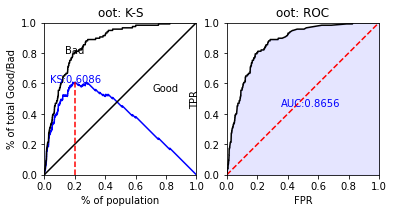

In [21]:
oot_perf_swh_bal = sc.perf_eva(oot5_copy['FLAG_MF'], oot5_copy['proba_swh_bal'], title = "oot")

In [22]:
print("Accuracy: ", accuracy_score(oot5_copy['FLAG_MF'], oot5_copy['proba_swh_bal'].round(0)))
print('-'*100)
print()

print("AUC: ", roc_auc_score(oot5_copy['FLAG_MF'],oot5_copy['proba_swh_bal']))
print('-'*100)
print("Gini: ", roc_auc_score(oot5_copy['FLAG_MF'], oot5_copy['proba_swh_bal'])*2-1)
print("\n")
#print("Gini train: ", roc_auc_score(train_copy['FLAG_MF'], train_copy['proba_swh_bal'])*2-1)
print('-'*100)
#print("Gini Train: ", roc_auc_score(data[train_lda_mask][col_target], predLDAPtrain)*2-1)
#print('-'*100)
print("Confusion Matrix:\n", confusion_matrix(oot5_copy['FLAG_MF'], oot5_copy['proba_swh_bal'].round(0)))
print('-'*100)
print()
print("Classification Report:\n", classification_report(oot5_copy['FLAG_MF'], oot5_copy['proba_swh_bal'].round(0)))

Accuracy:  0.9799353119006599
----------------------------------------------------------------------------------------------------

AUC:  0.8655592785986896
----------------------------------------------------------------------------------------------------
Gini:  0.7311185571973793


----------------------------------------------------------------------------------------------------
Confusion Matrix:
 [[120561   2374]
 [    95     22]]
----------------------------------------------------------------------------------------------------

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.98      0.99    122935
         1.0       0.01      0.19      0.02       117

    accuracy                           0.98    123052
   macro avg       0.50      0.58      0.50    123052
weighted avg       1.00      0.98      0.99    123052



In [23]:
decile_oot_lrswh_bal3 = pd.DataFrame(oot5_copy[['FLAG_MF','CRN']])
decile_oot_lrswh_bal3['score_swh_bal_'] = oot5_copy['score_swh_bal_']
#decile_oot_lrswh_bal3['Binning'] = pd.qcut(decile_oot_lrswh_bal3['score_swh_bal3'], q = 10)

binning = [-np.inf, 300.581,  317.338,  348.855, 374.826, 464.425, np.inf]
#binning = [-np.inf,  0.157,  0.2338, 0.2343, 0.2534,   0.2727,  0.353, 0.381 , 0.5193 ,  0.7001 , np.inf]
decile_oot_lrswh_bal3['Binning'] = pd.cut(decile_oot_lrswh_bal3['score_swh_bal_'], bins = binning)
 
decile_num = [1,2,3,4,5,6]
decile_oot_lrswh_bal3 = decile_oot_lrswh_bal3.groupby(['Binning','FLAG_MF'])[['CRN']].count().reset_index()
decile_oot_lrswh_bal3 = decile_oot_lrswh_bal3.pivot(index='Binning', columns='FLAG_MF', values='CRN').reset_index()

decile_oot_lrswh_bal3['Taker'] = decile_oot_lrswh_bal3[1].fillna(0)
decile_oot_lrswh_bal3['Non_Taker'] = decile_oot_lrswh_bal3[0].fillna(0)
decile_oot_lrswh_bal3['Freq'] =decile_oot_lrswh_bal3['Non_Taker'] + decile_oot_lrswh_bal3['Taker']

 
decile_oot_lrswh_bal3['Taker_Rate'] = decile_oot_lrswh_bal3['Taker'] / decile_oot_lrswh_bal3['Freq']
decile_oot_lrswh_bal3 = decile_oot_lrswh_bal3.reset_index().sort_values(by='index', ascending=False)
decile_oot_lrswh_bal3['Decile'] = decile_num
decile_oot_lrswh_bal3 = decile_oot_lrswh_bal3[['Decile', 'Binning', 'Taker', 'Non_Taker', 'Freq', 'Taker_Rate']]
decile_oot_lrswh_bal3['Dist'] = decile_oot_lrswh_bal3['Freq']/decile_oot_lrswh_bal3['Freq'].sum()*100
decile_oot_lrswh_bal3

FLAG_MF,Decile,Binning,Taker,Non_Taker,Freq,Taker_Rate,Dist
5,1,"(464.425, inf]",78.0,18548.0,18626.0,0.004188,15.136690
4,2,"(374.826, 464.425]",26.0,19738.0,19764.0,0.001316,16.061502
3,3,"(348.855, 374.826]",7.0,15222.0,15229.0,0.000460,12.376069
2,4,"(317.338, 348.855]",4.0,25302.0,25306.0,0.000158,20.565289
1,5,"(300.581, 317.338]",2.0,23958.0,23960.0,0.000083,19.471443
0,6,"(-inf, 300.581]",0.0,20167.0,20167.0,0.000000,16.389006


In [24]:
decile_train_lrswh_bal3 = pd.read_csv('/Users/22060909/Documents/Task/WMB/Python/MF2/OOT_Corrected/decile_train.csv', sep=";", index_col=False)

In [25]:
decile_train_lrswh_bal3

,FLAG_MF,Decile,Binning,Taker,Non_Taker,Freq,Taker_Rate,Dist,Cum_Good_%,Cum_Bad_%,KS,Diff_Cum_Good,Sum_Cum_Bad,AUC
0,5,1,"(464.425, 939.176]",82,14654,14736,0.005565,16.664405,1.000000,1.000000,0.000000,0.683333,1.834058,0.626637
1,4,2,"(374.826, 464.425]",25,14663,14688,0.001702,16.610123,0.316667,0.834058,0.517391,0.208333,1.502072,0.156466
2,3,3,"(348.855, 374.826]",6,13364,13370,0.000449,15.119645,0.108333,0.668014,0.559681,0.050000,1.184694,0.029617
3,2,4,"(317.338, 348.855]",3,14937,14940,0.000201,16.895101,0.058333,0.516680,0.458347,0.025000,0.864214,0.010803
4,1,5,"(300.581, 317.338]",3,15416,15419,0.000195,17.436785,0.033333,0.347534,0.314200,0.025000,0.520496,0.006506
5,0,6,"(44.498000000000005, 300.581]",1,15274,15275,0.000065,17.273940,0.008333,0.172963,0.164629,0.008333,0.172963,0.000721


In [26]:
decile_test_lrswh_bal3 = pd.read_csv('/Users/22060909/Documents/Task/WMB/Python/MF2/OOT_Corrected/decile_test.csv', sep=";", index_col=False)

In [27]:
decile_test_lrswh_bal3

,FLAG_MF,Decile,Binning,Taker,Non_Taker,Freq,Taker_Rate,Dist,Cum_Good_%,Cum_Bad_%,KS,Diff_Cum_Good,Sum_Cum_Bad,AUC
0,5,1,"(464.425, inf]",47,5606,5653,0.008314,14.837660,1.000000,1.000000,0.000000,0.796610,1.852629,0.737911
1,4,2,"(374.826, 464.425]",9,6436,6445,0.001396,16.916455,0.203390,0.852629,0.649239,0.152542,1.536067,0.117158
2,3,3,"(348.855, 374.826]",1,5577,5578,0.000179,14.640804,0.050847,0.683438,0.632591,0.016949,1.220268,0.010341
3,2,4,"(317.338, 348.855]",1,7306,7307,0.000137,19.178981,0.033898,0.536830,0.502931,0.016949,0.881598,0.007471
4,1,5,"(300.581, 317.338]",1,6773,6774,0.000148,17.779994,0.016949,0.344769,0.327820,0.016949,0.511488,0.004335
5,0,6,"(-inf, 300.581]",0,6342,6342,0.000000,16.646106,0.000000,0.166719,0.166719,0.000000,0.166719,0.000000


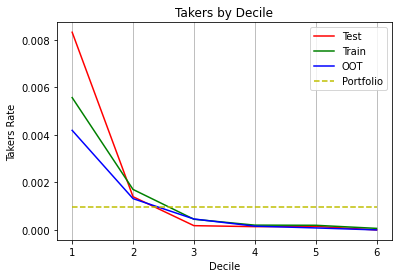

In [28]:
xpoints = np.array(decile_test_lrswh_bal3['Decile'])
ypoints = np.array(decile_test_lrswh_bal3['Taker_Rate'])
zpoints = np.array(decile_train_lrswh_bal3['Taker_Rate'])
qpoints = np.array(decile_oot_lrswh_bal3['Taker_Rate'])
tpoints = np.array([0.00095,0.00095,0.00095,0.00095,0.00095,0.00095])

plt.plot(xpoints, ypoints, color='r', label='Test') 
plt.plot(xpoints, zpoints, color='g', label='Train')
plt.plot(xpoints, qpoints, color='b', label='OOT')
plt.plot(xpoints, tpoints, color='y', label='Portfolio', linestyle='--')

plt.title("Takers by Decile")
plt.xlabel("Decile")
plt.ylabel("Takers Rate")

# Adding legend, which helps us recognize the curve according to it's color 
plt.legend() 
plt.grid(axis = 'x')
plt.xticks(xpoints)

plt.show()

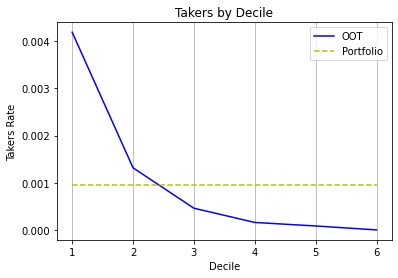

In [29]:
xpoints = np.array(decile_test_lrswh_bal3['Decile'])
#ypoints = np.array(decile_test_lrswh_bal3['Taker_Rate'])
#zpoints = np.array(decile_train_lrswh_bal3['Taker_Rate'])
qpoints = np.array(decile_oot_lrswh_bal3['Taker_Rate'])
tpoints = np.array([0.00095,0.00095,0.00095,0.00095,0.00095,0.00095])

#plt.plot(xpoints, ypoints, color='r', label='Test') 
#plt.plot(xpoints, zpoints, color='g', label='Train')
plt.plot(xpoints, qpoints, color='b', label='OOT')
plt.plot(xpoints, tpoints, color='y', label='Portfolio', linestyle='--')

plt.title("Takers by Decile")
plt.xlabel("Decile")
plt.ylabel("Takers Rate")

# Adding legend, which helps us recognize the curve according to it's color 
plt.legend() 
plt.grid(axis = 'x')
plt.xticks(xpoints)

plt.show()

In [30]:
Decile_PSI3 = pd.DataFrame()
Decile_PSI3['Decile'] = decile_train_lrswh_bal3['Decile']
Decile_PSI3['Binning'] = decile_train_lrswh_bal3['Binning']
Decile_PSI3['Pop_Pcnt_Train'] = decile_train_lrswh_bal3['Dist']/100
Decile_PSI3['Pop_Pcnt_Test'] = decile_test_lrswh_bal3['Dist']/100
Decile_PSI3['Test-Train'] = Decile_PSI3['Pop_Pcnt_Test'] - Decile_PSI3['Pop_Pcnt_Train']
Decile_PSI3['log'] =np.log(Decile_PSI3['Pop_Pcnt_Test']/Decile_PSI3['Pop_Pcnt_Train'])
Decile_PSI3['PSI'] =Decile_PSI3['Test-Train']*Decile_PSI3['log']

print(Decile_PSI3['PSI'].sum())
Decile_PSI3

0.0055261510760264


,Decile,Binning,Pop_Pcnt_Train,Pop_Pcnt_Test,Test-Train,log,PSI
0,1,"(464.425, 939.176]",0.166644,0.148377,-0.018267,-0.116106,0.002121
1,2,"(374.826, 464.425]",0.166101,0.169165,0.003063,0.018274,0.000056
2,3,"(348.855, 374.826]",0.151196,0.146408,-0.004788,-0.032182,0.000154
3,4,"(317.338, 348.855]",0.168951,0.191790,0.022839,0.126791,0.002896
4,5,"(300.581, 317.338]",0.174368,0.177800,0.003432,0.019492,0.000067
5,6,"(44.498000000000005, 300.581]",0.172739,0.166461,-0.006278,-0.037023,0.000232


In [31]:
Decile_PSI3 = pd.merge(Decile_PSI3, decile_oot_lrswh_bal3[['Decile','Dist']], how='left', left_on='Decile', right_on ='Decile', indicator=False)
Decile_PSI3.rename(columns={'Dist':'Pop_Pcnt_OOT'}, inplace=True)

In [32]:
Decile_PSI3['Pop_Pcnt_OOT'] = Decile_PSI3['Pop_Pcnt_OOT']/100

Decile_PSI3['OOT-Train'] = Decile_PSI3['Pop_Pcnt_OOT'] - Decile_PSI3['Pop_Pcnt_Train']
Decile_PSI3['log_OOT'] =np.log(Decile_PSI3['Pop_Pcnt_OOT']/Decile_PSI3['Pop_Pcnt_Train'])
Decile_PSI3['PSI_OOT'] =Decile_PSI3['OOT-Train']*Decile_PSI3['log_OOT']

print(Decile_PSI3['PSI_OOT'].sum())
Decile_PSI3

0.017072536499539995


,Decile,Binning,Pop_Pcnt_Train,Pop_Pcnt_Test,Test-Train,log,PSI,Pop_Pcnt_OOT,OOT-Train,log_OOT,PSI_OOT
0,1,"(464.425, 939.176]",0.166644,0.148377,-0.018267,-0.116106,0.002121,0.151367,-0.015277,-0.096153,0.001469
1,2,"(374.826, 464.425]",0.166101,0.169165,0.003063,0.018274,0.000056,0.160615,-0.005486,-0.033587,0.000184
2,3,"(348.855, 374.826]",0.151196,0.146408,-0.004788,-0.032182,0.000154,0.123761,-0.027436,-0.200230,0.005493
3,4,"(317.338, 348.855]",0.168951,0.191790,0.022839,0.126791,0.002896,0.205653,0.036702,0.196581,0.007215
4,5,"(300.581, 317.338]",0.174368,0.177800,0.003432,0.019492,0.000067,0.194714,0.020347,0.110367,0.002246
5,6,"(44.498000000000005, 300.581]",0.172739,0.166461,-0.006278,-0.037023,0.000232,0.163890,-0.008849,-0.052588,0.000465


In [33]:
decile_oot_lrswh_bal3 = decile_oot_lrswh_bal3.sort_values('Decile', ascending = False)

In [34]:
#KS
decile_oot_lrswh_bal3['Cum_Good_%'] = decile_oot_lrswh_bal3['Taker'].cumsum(axis = 0, skipna = True)/decile_oot_lrswh_bal3['Taker'].sum()
decile_oot_lrswh_bal3['Cum_Bad_%'] = decile_oot_lrswh_bal3['Non_Taker'].cumsum(axis = 0, skipna = True)/decile_oot_lrswh_bal3['Non_Taker'].sum()
decile_oot_lrswh_bal3['KS'] = abs(decile_oot_lrswh_bal3['Cum_Good_%']-decile_oot_lrswh_bal3['Cum_Bad_%'])


#AUC
decile_oot_lrswh_bal3['Diff_Cum_Good'] = decile_oot_lrswh_bal3['Cum_Good_%'].diff()
decile_oot_lrswh_bal3['Diff_Cum_Good'] = decile_oot_lrswh_bal3['Diff_Cum_Good'].fillna(decile_oot_lrswh_bal3['Cum_Good_%'])
decile_oot_lrswh_bal3['Sum_Cum_Bad'] = decile_oot_lrswh_bal3['Cum_Bad_%']
 
for i in range(1,6):
    decile_oot_lrswh_bal3['Sum_Cum_Bad'].iloc[i] = decile_oot_lrswh_bal3['Cum_Bad_%'].iloc[i-1:i+1].sum()
decile_oot_lrswh_bal3['AUC'] = decile_oot_lrswh_bal3['Diff_Cum_Good']*decile_oot_lrswh_bal3['Sum_Cum_Bad']*1/2
 
decile_oot_lrswh_bal3 = decile_oot_lrswh_bal3.sort_values('Decile', ascending = True)
decile_oot_lrswh_bal3

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


FLAG_MF,Decile,Binning,Taker,Non_Taker,Freq,Taker_Rate,Dist,Cum_Good_%,Cum_Bad_%,KS,Diff_Cum_Good,Sum_Cum_Bad,AUC
5,1,"(464.425, inf]",78.0,18548.0,18626.0,0.004188,15.136690,1.000000,1.000000,0.000000,0.666667,1.849124,0.616375
4,2,"(374.826, 464.425]",26.0,19738.0,19764.0,0.001316,16.061502,0.333333,0.849124,0.515790,0.222222,1.537691,0.170855
3,3,"(348.855, 374.826]",7.0,15222.0,15229.0,0.000460,12.376069,0.111111,0.688567,0.577456,0.059829,1.253313,0.037492
2,4,"(317.338, 348.855]",4.0,25302.0,25306.0,0.000158,20.565289,0.051282,0.564746,0.513464,0.034188,0.923675,0.015789
1,5,"(300.581, 317.338]",2.0,23958.0,23960.0,0.000083,19.471443,0.017094,0.358930,0.341835,0.017094,0.522976,0.004470
0,6,"(-inf, 300.581]",0.0,20167.0,20167.0,0.000000,16.389006,0.000000,0.164046,0.164046,0.000000,0.164046,0.000000


In [35]:
# by decile

performance3 = pd.DataFrame([[decile_train_lrswh_bal3['KS'].max(),
                             decile_train_lrswh_bal3['AUC'].sum(),
                             2*decile_train_lrswh_bal3['AUC'].sum()-1
                            ],
                            [decile_test_lrswh_bal3['KS'].max(),
                             decile_test_lrswh_bal3['AUC'].sum(),
                             2*decile_test_lrswh_bal3['AUC'].sum()-1
                            ],
                            [decile_oot_lrswh_bal3['KS'].max(),
                             decile_oot_lrswh_bal3['AUC'].sum(),
                             2*decile_oot_lrswh_bal3['AUC'].sum()-1
                            ]
                           ]
                           , columns=["KS", "AUC", "Gini"])

performance3.index = ['Train', 'Test','OOT']
performance3

,KS,AUC,Gini
Train,0.559681,0.830750,0.661500
Test,0.649239,0.877216,0.754432
OOT,0.577456,0.844980,0.689961


# CSI

In [36]:
# Define Characteristic Analysis Function
def char_analysis(df,attribute,target):
    df2 = df[[target,attribute]]
    if  df[attribute].isnull().values.any() ==True:
        df2.loc[df[attribute].isnull(),attribute] = "Empty"
        analysis = df2.groupby(attribute, as_index = False, dropna=False)[target].agg(['sum','count'])
        analysis['dist'] = analysis['count']/ analysis['count'].sum()
        analysis['taker_rate'] = analysis['sum']/ analysis['count']
        analysis['attribute'] = analysis.index.name
        analysis.index.name = 'woe'
    else:
        #df2.loc[df[attribute].isnull(),attribute] = "Empty"
        analysis = df2.groupby(attribute, as_index = False, dropna=False)[target].agg(['sum','count'])
        analysis['dist'] = analysis['count']/ analysis['count'].sum()
        analysis['taker_rate'] = analysis['sum']/ analysis['count']
        analysis['attribute'] = analysis.index.name
        analysis.index.name = 'woe'
    
    
    
    
    
# faster method
    df3 = pd.merge(df2, analysis[['sum','count']], left_on=attribute , right_index =True, indicator=False)
    


    return analysis

In [37]:
csi = pd.read_csv('/Users/22060909/Documents/Task/WMB/Python/MF2/csi_final.csv', index_col=False)

In [38]:
 csi = csi.drop(['Unnamed: 0'], axis = 1)

In [39]:
pd.set_option('display.max_columns', None)
csi

,variable,coef,woe,BiXi,total_iv,bin,points,train_cnt,train_takers,train_dist,train_takers%,test_cnt,test_takers,test_dist,test_takers%,attribute,woe_7,oot_cnt,oot_takers,oot_dist,oot_takers%,OOT_CSI,log_OOT_CSI,CSI_OOT,Test_CSI,log_Test_CSI,CSI_Test
0,growth_pct_Trf_out_Trx_cnt,0.419093,-0.422279,-0.176974,0.444042,missing,26.968633,75279.0,67.0,0.851303,0.000890,32413.0,20.0,0.850757,0.000617,growth_pct_Trf_out_Trx_cnt,-0.42220,103890.0,46.0,0.849052,0.000443,-0.002251,-0.002647,5.958757e-06,-0.000546,-0.000641,3.496808e-07
1,growth_pct_Trf_out_Trx_cnt,0.419093,1.091324,0.457366,0.444042,"[-inf,inf)",72.726582,13149.0,53.0,0.148697,0.004031,5686.0,39.0,0.149243,0.006859,growth_pct_Trf_out_Trx_cnt,1.09132,18470.0,69.0,0.150948,0.003736,0.002251,0.015023,3.381393e-05,0.000546,0.003662,1.997645e-06
2,mob_fin,2.193467,1.082304,2.373997,0.179483,"[-inf,10.0)",210.982282,6008.0,24.0,0.067942,0.003995,907.0,2.0,0.023806,0.002205,mob_fin,1.08230,2063.0,2.0,0.016860,0.000969,-0.051082,-1.393710,7.119374e-02,-0.044136,-1.048704,4.628548e-02
3,mob_fin,2.193467,0.129469,0.283987,0.179483,"[10.0,20.0)",60.219946,9713.0,15.0,0.109841,0.001544,4317.0,5.0,0.113310,0.001158,mob_fin,0.12946,8446.0,7.0,0.069026,0.000829,-0.040815,-0.464551,1.896063e-02,0.003469,0.031096,1.078814e-04
4,mob_fin,2.193467,-0.140544,-0.308279,0.179483,"[20.0,60.0)",17.496966,48333.0,57.0,0.546580,0.001179,21677.0,38.0,0.568965,0.001753,mob_fin,-0.14050,77909.0,61.0,0.636720,0.000783,0.090139,0.152648,1.375958e-02,0.022385,0.040138,8.984778e-04
5,mob_fin,2.193467,-0.321139,-0.704408,0.179483,"[60.0,inf)",-11.077669,24374.0,24.0,0.275637,0.000985,11198.0,14.0,0.293918,0.001250,mob_fin,-0.32110,33942.0,45.0,0.277395,0.001326,0.001758,0.006357,1.117555e-05,0.018282,0.064219,1.174036e-03
6,education,0.522539,-0.454816,-0.237659,0.285826,"1%,%2%,%3",22.591150,15089.0,13.0,0.170636,0.000862,6538.0,8.0,0.171606,0.001224,education,-0.45480,20908.0,10.0,0.170873,0.000478,0.000237,0.001387,3.284928e-07,0.000970,0.005666,5.493441e-06
7,education,0.522539,0.577750,0.301897,0.285826,"4%,%5%,%6",61.511880,28977.0,70.0,0.327690,0.002416,13005.0,36.0,0.341348,0.002768,education,0.57775,41238.0,70.0,0.337022,0.001697,0.009332,0.028079,2.620204e-04,0.013657,0.040832,5.576531e-04
8,education,0.522539,1.282974,0.670404,0.285826,7,88.094028,205.0,1.0,0.002318,0.004878,104.0,2.0,0.002730,0.019231,education,1.28297,309.0,0.0,0.002525,0.000000,0.000207,0.085552,1.771490e-05,0.000411,0.163382,6.722501e-05
9,education,0.522539,-0.510078,-0.266536,0.285826,"missing%,%''%,%8",20.508140,44157.0,36.0,0.499355,0.000815,18452.0,13.0,0.484317,0.000705,education,-0.51000,59905.0,35.0,0.489580,0.000584,-0.009775,-0.019770,1.932646e-04,-0.015038,-0.030578,4.598402e-04


In [40]:
# reset oot value

csi = csi.drop(csi.filter(regex='oot').columns, axis=1)
csi = csi.drop(csi.filter(regex='OOT').columns, axis=1)
csi

,variable,coef,woe,BiXi,total_iv,bin,points,train_cnt,train_takers,train_dist,train_takers%,test_cnt,test_takers,test_dist,test_takers%,attribute,woe_7,Test_CSI,log_Test_CSI,CSI_Test
0,growth_pct_Trf_out_Trx_cnt,0.419093,-0.422279,-0.176974,0.444042,missing,26.968633,75279.0,67.0,0.851303,0.000890,32413.0,20.0,0.850757,0.000617,growth_pct_Trf_out_Trx_cnt,-0.42220,-0.000546,-0.000641,3.496808e-07
1,growth_pct_Trf_out_Trx_cnt,0.419093,1.091324,0.457366,0.444042,"[-inf,inf)",72.726582,13149.0,53.0,0.148697,0.004031,5686.0,39.0,0.149243,0.006859,growth_pct_Trf_out_Trx_cnt,1.09132,0.000546,0.003662,1.997645e-06
2,mob_fin,2.193467,1.082304,2.373997,0.179483,"[-inf,10.0)",210.982282,6008.0,24.0,0.067942,0.003995,907.0,2.0,0.023806,0.002205,mob_fin,1.08230,-0.044136,-1.048704,4.628548e-02
3,mob_fin,2.193467,0.129469,0.283987,0.179483,"[10.0,20.0)",60.219946,9713.0,15.0,0.109841,0.001544,4317.0,5.0,0.113310,0.001158,mob_fin,0.12946,0.003469,0.031096,1.078814e-04
4,mob_fin,2.193467,-0.140544,-0.308279,0.179483,"[20.0,60.0)",17.496966,48333.0,57.0,0.546580,0.001179,21677.0,38.0,0.568965,0.001753,mob_fin,-0.14050,0.022385,0.040138,8.984778e-04
5,mob_fin,2.193467,-0.321139,-0.704408,0.179483,"[60.0,inf)",-11.077669,24374.0,24.0,0.275637,0.000985,11198.0,14.0,0.293918,0.001250,mob_fin,-0.32110,0.018282,0.064219,1.174036e-03
6,education,0.522539,-0.454816,-0.237659,0.285826,"1%,%2%,%3",22.591150,15089.0,13.0,0.170636,0.000862,6538.0,8.0,0.171606,0.001224,education,-0.45480,0.000970,0.005666,5.493441e-06
7,education,0.522539,0.577750,0.301897,0.285826,"4%,%5%,%6",61.511880,28977.0,70.0,0.327690,0.002416,13005.0,36.0,0.341348,0.002768,education,0.57775,0.013657,0.040832,5.576531e-04
8,education,0.522539,1.282974,0.670404,0.285826,7,88.094028,205.0,1.0,0.002318,0.004878,104.0,2.0,0.002730,0.019231,education,1.28297,0.000411,0.163382,6.722501e-05
9,education,0.522539,-0.510078,-0.266536,0.285826,"missing%,%''%,%8",20.508140,44157.0,36.0,0.499355,0.000815,18452.0,13.0,0.484317,0.000705,education,-0.51000,-0.015038,-0.030578,4.598402e-04


In [41]:
chars_oot2 =pd.DataFrame()
for i in var_final:
    char_oot2 = char_analysis(oot5_copy,i,'FLAG_MF')
    chars_oot2 = pd.concat([chars_oot2, char_oot2])

In [42]:
b = chars_oot2[['count','sum','dist','taker_rate']]#,'attribute']]
b.rename(columns={'sum':'oot_takers',
                  'count':'oot_cnt',
                  'dist':'oot_dist',
                  'taker_rate': 'oot_takers%'
                  #'attribute' : 'variable'
                   }, inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [43]:
csi

,variable,coef,woe,BiXi,total_iv,bin,points,train_cnt,train_takers,train_dist,train_takers%,test_cnt,test_takers,test_dist,test_takers%,attribute,woe_7,Test_CSI,log_Test_CSI,CSI_Test
0,growth_pct_Trf_out_Trx_cnt,0.419093,-0.422279,-0.176974,0.444042,missing,26.968633,75279.0,67.0,0.851303,0.000890,32413.0,20.0,0.850757,0.000617,growth_pct_Trf_out_Trx_cnt,-0.42220,-0.000546,-0.000641,3.496808e-07
1,growth_pct_Trf_out_Trx_cnt,0.419093,1.091324,0.457366,0.444042,"[-inf,inf)",72.726582,13149.0,53.0,0.148697,0.004031,5686.0,39.0,0.149243,0.006859,growth_pct_Trf_out_Trx_cnt,1.09132,0.000546,0.003662,1.997645e-06
2,mob_fin,2.193467,1.082304,2.373997,0.179483,"[-inf,10.0)",210.982282,6008.0,24.0,0.067942,0.003995,907.0,2.0,0.023806,0.002205,mob_fin,1.08230,-0.044136,-1.048704,4.628548e-02
3,mob_fin,2.193467,0.129469,0.283987,0.179483,"[10.0,20.0)",60.219946,9713.0,15.0,0.109841,0.001544,4317.0,5.0,0.113310,0.001158,mob_fin,0.12946,0.003469,0.031096,1.078814e-04
4,mob_fin,2.193467,-0.140544,-0.308279,0.179483,"[20.0,60.0)",17.496966,48333.0,57.0,0.546580,0.001179,21677.0,38.0,0.568965,0.001753,mob_fin,-0.14050,0.022385,0.040138,8.984778e-04
5,mob_fin,2.193467,-0.321139,-0.704408,0.179483,"[60.0,inf)",-11.077669,24374.0,24.0,0.275637,0.000985,11198.0,14.0,0.293918,0.001250,mob_fin,-0.32110,0.018282,0.064219,1.174036e-03
6,education,0.522539,-0.454816,-0.237659,0.285826,"1%,%2%,%3",22.591150,15089.0,13.0,0.170636,0.000862,6538.0,8.0,0.171606,0.001224,education,-0.45480,0.000970,0.005666,5.493441e-06
7,education,0.522539,0.577750,0.301897,0.285826,"4%,%5%,%6",61.511880,28977.0,70.0,0.327690,0.002416,13005.0,36.0,0.341348,0.002768,education,0.57775,0.013657,0.040832,5.576531e-04
8,education,0.522539,1.282974,0.670404,0.285826,7,88.094028,205.0,1.0,0.002318,0.004878,104.0,2.0,0.002730,0.019231,education,1.28297,0.000411,0.163382,6.722501e-05
9,education,0.522539,-0.510078,-0.266536,0.285826,"missing%,%''%,%8",20.508140,44157.0,36.0,0.499355,0.000815,18452.0,13.0,0.484317,0.000705,education,-0.51000,-0.015038,-0.030578,4.598402e-04


In [44]:
b['woe'] = b.index
b['woe_r'] =b['woe'].round(6)
csi['woe_r'] = csi['woe'].round(6)
b = b.drop(['woe'], axis=1)

In [45]:
csi =pd.merge(csi,b,
                            how='left',
                            left_on='woe_r', right_on ='woe_r', indicator=False)  
csi

,variable,coef,woe,BiXi,total_iv,bin,points,train_cnt,train_takers,train_dist,train_takers%,test_cnt,test_takers,test_dist,test_takers%,attribute,woe_7,Test_CSI,log_Test_CSI,CSI_Test,woe_r,oot_cnt,oot_takers,oot_dist,oot_takers%
0,growth_pct_Trf_out_Trx_cnt,0.419093,-0.422279,-0.176974,0.444042,missing,26.968633,75279.0,67.0,0.851303,0.000890,32413.0,20.0,0.850757,0.000617,growth_pct_Trf_out_Trx_cnt,-0.42220,-0.000546,-0.000641,3.496808e-07,-0.422279,104426.0,47.0,0.848633,0.000450
1,growth_pct_Trf_out_Trx_cnt,0.419093,1.091324,0.457366,0.444042,"[-inf,inf)",72.726582,13149.0,53.0,0.148697,0.004031,5686.0,39.0,0.149243,0.006859,growth_pct_Trf_out_Trx_cnt,1.09132,0.000546,0.003662,1.997645e-06,1.091324,18626.0,70.0,0.151367,0.003758
2,mob_fin,2.193467,1.082304,2.373997,0.179483,"[-inf,10.0)",210.982282,6008.0,24.0,0.067942,0.003995,907.0,2.0,0.023806,0.002205,mob_fin,1.08230,-0.044136,-1.048704,4.628548e-02,1.082304,2755.0,4.0,0.022389,0.001452
3,mob_fin,2.193467,0.129469,0.283987,0.179483,"[10.0,20.0)",60.219946,9713.0,15.0,0.109841,0.001544,4317.0,5.0,0.113310,0.001158,mob_fin,0.12946,0.003469,0.031096,1.078814e-04,0.129469,8446.0,7.0,0.068638,0.000829
4,mob_fin,2.193467,-0.140544,-0.308279,0.179483,"[20.0,60.0)",17.496966,48333.0,57.0,0.546580,0.001179,21677.0,38.0,0.568965,0.001753,mob_fin,-0.14050,0.022385,0.040138,8.984778e-04,-0.140544,77909.0,61.0,0.633139,0.000783
5,mob_fin,2.193467,-0.321139,-0.704408,0.179483,"[60.0,inf)",-11.077669,24374.0,24.0,0.275637,0.000985,11198.0,14.0,0.293918,0.001250,mob_fin,-0.32110,0.018282,0.064219,1.174036e-03,-0.321139,33942.0,45.0,0.275835,0.001326
6,education,0.522539,-0.454816,-0.237659,0.285826,"1%,%2%,%3",22.591150,15089.0,13.0,0.170636,0.000862,6538.0,8.0,0.171606,0.001224,education,-0.45480,0.000970,0.005666,5.493441e-06,-0.454816,20959.0,10.0,0.170326,0.000477
7,education,0.522539,0.577750,0.301897,0.285826,"4%,%5%,%6",61.511880,28977.0,70.0,0.327690,0.002416,13005.0,36.0,0.341348,0.002768,education,0.57775,0.013657,0.040832,5.576531e-04,0.577750,41400.0,72.0,0.336443,0.001739
8,education,0.522539,1.282974,0.670404,0.285826,7,88.094028,205.0,1.0,0.002318,0.004878,104.0,2.0,0.002730,0.019231,education,1.28297,0.000411,0.163382,6.722501e-05,1.282974,310.0,0.0,0.002519,0.000000
9,education,0.522539,-0.510078,-0.266536,0.285826,"missing%,%''%,%8",20.508140,44157.0,36.0,0.499355,0.000815,18452.0,13.0,0.484317,0.000705,education,-0.51000,-0.015038,-0.030578,4.598402e-04,-0.510078,60383.0,35.0,0.490711,0.000580


In [46]:
CSI = csi.copy()

In [47]:
CSI['OOT_CSI'] = CSI['oot_dist'] - CSI['train_dist']
CSI['log_OOT_CSI'] =np.log(CSI['oot_dist']/CSI['train_dist'])
CSI['CSI_OOT'] =CSI['OOT_CSI']*CSI['log_OOT_CSI']

CSI['Test_CSI'] = CSI['test_dist'] - CSI['train_dist']
CSI['log_Test_CSI'] =np.log(CSI['test_dist']/CSI['train_dist'])
CSI['CSI_Test'] =CSI['Test_CSI']*CSI['log_Test_CSI']


CSI_sum = CSI.groupby('variable', as_index = False, dropna=False)['CSI_OOT','CSI_Test'].agg(['sum'])
#CSI_sum['sum'].rename(columns={'sum':'csi_oot'}, inplace=True)
#CSI_sum.sort_values('sum', ascending=False)

CSI_sum

<ipython-input-47-e81f0b863bc4>:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  CSI_sum = CSI.groupby('variable', as_index = False, dropna=False)['CSI_OOT','CSI_Test'].agg(['sum'])


,CSI_OOT,CSI_Test
,sum,sum
variable,,
age,0.000040,0.000112
current_funding_trx_amt_over_max,0.019815,0.001007
education,0.000399,0.001090
growth_pct_Trf_out_Trx_cnt,0.000056,0.000002
intercept,0.000000,0.000000
m0_sny_total_aum_cnt,0.000188,0.001010
marital_status,0.000044,0.000045
max_pastduedays_l19m,0.002215,0.000008


In [48]:
CSI

,variable,coef,woe,BiXi,total_iv,bin,points,train_cnt,train_takers,train_dist,train_takers%,test_cnt,test_takers,test_dist,test_takers%,attribute,woe_7,Test_CSI,log_Test_CSI,CSI_Test,woe_r,oot_cnt,oot_takers,oot_dist,oot_takers%,OOT_CSI,log_OOT_CSI,CSI_OOT
0,growth_pct_Trf_out_Trx_cnt,0.419093,-0.422279,-0.176974,0.444042,missing,26.968633,75279.0,67.0,0.851303,0.000890,32413.0,20.0,0.850757,0.000617,growth_pct_Trf_out_Trx_cnt,-0.42220,-0.000546,-0.000641,3.496808e-07,-0.422279,104426.0,47.0,0.848633,0.000450,-0.002670,-0.003141,8.385107e-06
1,growth_pct_Trf_out_Trx_cnt,0.419093,1.091324,0.457366,0.444042,"[-inf,inf)",72.726582,13149.0,53.0,0.148697,0.004031,5686.0,39.0,0.149243,0.006859,growth_pct_Trf_out_Trx_cnt,1.09132,0.000546,0.003662,1.997645e-06,1.091324,18626.0,70.0,0.151367,0.003758,0.002670,0.017794,4.750487e-05
2,mob_fin,2.193467,1.082304,2.373997,0.179483,"[-inf,10.0)",210.982282,6008.0,24.0,0.067942,0.003995,907.0,2.0,0.023806,0.002205,mob_fin,1.08230,-0.044136,-1.048704,4.628548e-02,1.082304,2755.0,4.0,0.022389,0.001452,-0.045553,-1.110093,5.056847e-02
3,mob_fin,2.193467,0.129469,0.283987,0.179483,"[10.0,20.0)",60.219946,9713.0,15.0,0.109841,0.001544,4317.0,5.0,0.113310,0.001158,mob_fin,0.12946,0.003469,0.031096,1.078814e-04,0.129469,8446.0,7.0,0.068638,0.000829,-0.041203,-0.470191,1.937332e-02
4,mob_fin,2.193467,-0.140544,-0.308279,0.179483,"[20.0,60.0)",17.496966,48333.0,57.0,0.546580,0.001179,21677.0,38.0,0.568965,0.001753,mob_fin,-0.14050,0.022385,0.040138,8.984778e-04,-0.140544,77909.0,61.0,0.633139,0.000783,0.086559,0.147009,1.272485e-02
5,mob_fin,2.193467,-0.321139,-0.704408,0.179483,"[60.0,inf)",-11.077669,24374.0,24.0,0.275637,0.000985,11198.0,14.0,0.293918,0.001250,mob_fin,-0.32110,0.018282,0.064219,1.174036e-03,-0.321139,33942.0,45.0,0.275835,0.001326,0.000198,0.000718,1.420796e-07
6,education,0.522539,-0.454816,-0.237659,0.285826,"1%,%2%,%3",22.591150,15089.0,13.0,0.170636,0.000862,6538.0,8.0,0.171606,0.001224,education,-0.45480,0.000970,0.005666,5.493441e-06,-0.454816,20959.0,10.0,0.170326,0.000477,-0.000310,-0.001816,5.623596e-07
7,education,0.522539,0.577750,0.301897,0.285826,"4%,%5%,%6",61.511880,28977.0,70.0,0.327690,0.002416,13005.0,36.0,0.341348,0.002768,education,0.57775,0.013657,0.040832,5.576531e-04,0.577750,41400.0,72.0,0.336443,0.001739,0.008753,0.026360,2.307248e-04
8,education,0.522539,1.282974,0.670404,0.285826,7,88.094028,205.0,1.0,0.002318,0.004878,104.0,2.0,0.002730,0.019231,education,1.28297,0.000411,0.163382,6.722501e-05,1.282974,310.0,0.0,0.002519,0.000000,0.000201,0.083144,1.671110e-05
9,education,0.522539,-0.510078,-0.266536,0.285826,"missing%,%''%,%8",20.508140,44157.0,36.0,0.499355,0.000815,18452.0,13.0,0.484317,0.000705,education,-0.51000,-0.015038,-0.030578,4.598402e-04,-0.510078,60383.0,35.0,0.490711,0.000580,-0.008644,-0.017462,1.509463e-04


In [ ]:
oot5_copy['FLAG_MF'] = oot5_copy['FLAG_MF'].fillna(0)

In [ ]:
oot5_copy['proba_swh_bal3'] = modelSW_bal3.predict(oot5_copy[var_final])